In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc3 as pm
import arviz as az

import theano
import theano.tensor as tt

sns.set_style("whitegrid")

# Сравнение моделей

## Теория вопроса

### Проверка апостериорного распределения



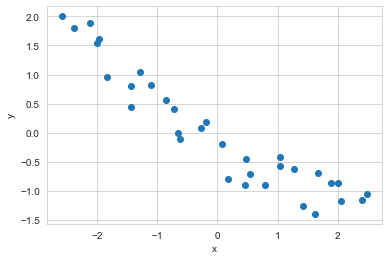

In [5]:
dummy_data = np.loadtxt('dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))
x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x');
plt.ylabel('y');


In [6]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_l = pm.sample(2000)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ϵ, β, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ϵ, β, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8864692589999861, but should be close to 0.8. Try to increase the number of tuning steps.


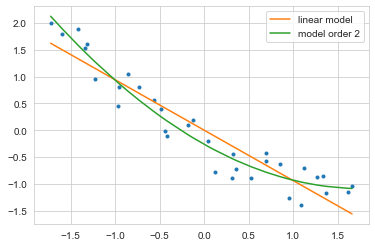

In [4]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')


plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend();

In [7]:
y_l = pm.sample_posterior_predictive(trace_l, 2000,
                                     model=model_l)['y_pred']

y_p = pm.sample_posterior_predictive(trace_p, 2000,
                                     model=model_p)['y_pred']

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


([], [])

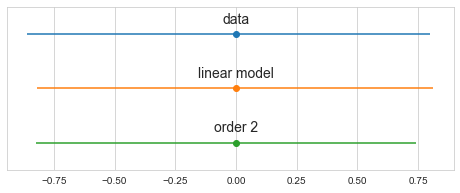

In [10]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

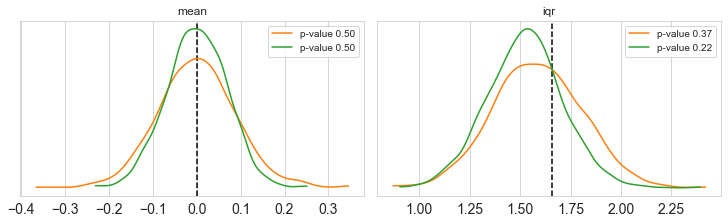

In [13]:

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)


def iqr(x, axis=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=axis)) # МАГИЧЕСКАЯ команда распаковки кортежа для его распаковки и передаци вычисления


for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, axis=1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

Байесовский p-value это вероятность получения имитационной статистической характеристики $T_{sim}$, большей или равной, чем статистическая характеристика реальных данных $T_{obs}$. Здесь $T$ может быть практически любой характеристикой, которая предоставляет возможность получения обобщенного результата по исследуемым данным.

На схеме указаны среднее значение на левой диаграмме и стандартное отклонение на правой диаграмме. 

Характеристика T должна выбираться с учетом ответа на вопрос, который стал главной побудительной причиной выполнения статистического вывода.

Рассматриваемые здесь p-value являются байесовскими, потому что для распределения сэмплирования (выборки) мы используем прогнозируемое апостериорное распределение. Также отметим, что здесь мы не принимаем во внимание какие-либо нулевые гипотезы (предположения), фактически мы имеем полное апостериорное распределение для $\theta$ и рассматриваем только условия, связанные с наблюдаемыми реальными данными. 

Еще одно отличие состоит в том, что мы не используем какое-либо предварительно определенное пороговое значение для объявления статистической значимости, а кроме того, не проводим проверки гипотез – мы лишь пытаемся найти числовое значение для оценки соответствия прогнозируемого апостериорного распределения наблюдаемому исходному набору данных.

### Информационные критерии

Информационные критерии – это набор различных, иногда взаимосвязанных инструментальных средств, которые используются для сравнения моделей в отношении того, насколько точно они соответствуют конкретным данным, при этом сложность моделей учитывается через штрафные факторы. 

Нам необходим надежный способ достижения баланса между степенью точности объяснения данных моделью, с одной стороны, и степенью сложности модели – с другой.

На данный момент самыми наиболее пчасто применимыми критериями являются:
* WAIC (widely applicable information criterion or Watanabe-Aikake information criterion) информационный критерий Ватанабе–Аикаке
* LOO (LOOCV) - Парето-сглаженная выборка по значимости для перекрестной проверки. При перекрестной проверке данные многократно разделяются на тренировочный и тестовый набор, итеративно подбирая модель и оценивая соответствие с тестовыми данными.

Мы не будем подробно останавливаться на данных критериях, однако отметич, что они "делают": 
* WAIC содержит два элемента: первый измеряет степень соответствия данных и модели, второй – штрафует сложные модели
* основная идея заключается в возможности аппроксимации LOOCV при помощи соответствующего перерасчета весовых коэффициентов правдоподоби. Проблема заключается в том, что результаты нестабильны. Для устранения нестабильности был введен новый метод с применением подхода, названного парето-сглаженной выборкой по значимости для перекрестной проверки LOOCV (Pareto-smoothed importance sampling – PSIS), который может применяться для вычисления более надежных оценок LOOCV. Интерпретация этого метода похожа на интерпретацию критерия WAIC: чем меньше значение, тем выше оцениваемая прогнозируемая точность рассматриваемой модели. 

Таким образом, наиболее предпочтительны модели с более низкими значениями.

## Простой пример

Оценка эффективности тренинга по подготовке к сдаче экзамена SAT (отдаленный аналог ЕГЭ) в 8 американских школах.
Раасотрим две модели:
* стандартную модель с единым фиксированным эффектом от тренингов:
* иерархическую модель, которая лишь частично объединяет данные, допуская существования для каждых собственных случайных эфектов.

In [14]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [15]:
with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sigma=1e6)
    obs = pm.Normal('obs', mu, sigma=sigma, observed=y)
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 9 seconds.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


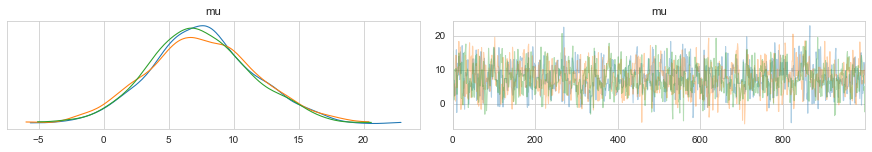

In [16]:
az.plot_trace(trace_p);

In [17]:
with pm.Model() as hierarchical:
    eta = pm.Normal('eta', 0, 1, shape=J)
    tau = pm.HalfCauchy('tau', 5)
    mu = pm.Normal('mu', 0, sigma=1e6)
    theta = pm.Deterministic('theta', mu + tau*eta)
    obs = pm.Normal('obs', theta, sigma=sigma, observed=y)
    trace_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu, tau, eta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 8 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


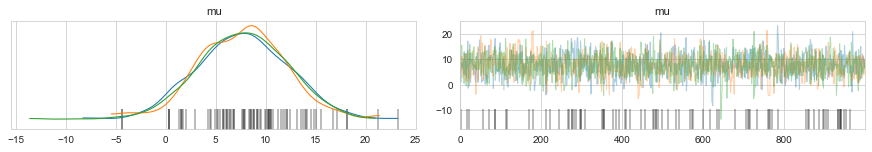

In [18]:
az.plot_trace(trace_h, var_names=['mu']);

In [19]:
display(az.summary(trace_p,var_names=['mu']))
display(az.summary(trace_h,var_names=['mu']))

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,7.511,4.079,-0.272,15.037,0.105,0.074,1515.0,1515.0,1503.0,2201.0,1.0


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,7.667,4.424,-0.245,16.087,0.102,0.074,1864.0,1792.0,1882.0,1681.0,1.0


In [20]:
az.waic(trace_p, pooled, scale = 'deviance')

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 3000 by 8 log-likelihood matrix

              Estimate       SE
deviance_waic    61.10     2.24
p_waic            0.66        -

In [21]:
pooled_waic = az.waic(trace_p, pooled)
pooled_waic

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 3000 by 8 log-likelihood matrix

          Estimate       SE
elpd_waic   -30.55     1.12
p_waic        0.66        -

In [22]:
hierarchical_waic = pm.waic(trace_h, hierarchical)
hierarchical_waic 

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 3000 by 8 log-likelihood matrix

          Estimate       SE
elpd_waic   -30.72     1.00
p_waic        1.01        -

In [23]:
df_comp_WAIC = az.compare({'hierarchical': trace_h, 'pooled': trace_p}, 
                          ic="waic")#, scale = 'deviance'
df_comp_WAIC

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  war

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
pooled,0,-30.5509,0.664178,0,0.539562,0.970439,0,False,log
hierarchical,1,-30.7154,1.01077,0.164501,0.460438,1.08561,0.142059,False,log


Результат сравнения:
* rank - ранг модели, лучшая имеет ранг 0
* waic - содержит значения WAIC в масштабе указанном в последнем столбце waic_scale. DataFrame всегда сортируется от самого низкого WAIC до самого высокого.
* p_waic - оценка эффективного количества параметров. Дает подсказку насколько модель гибка в подборе образца. 
* d_waic – относительная разность между значением WAIC для модели с наивысшей оценкой и значениями WAIC для каждой последующей модели. Поэтому для первой модели в этом столбце всегда находится значение 0.
* weight. Иногда при сравнении моделей не требуется выбирать самую лучшую модель. Вместо этого необходимы прогнозы по усредненным характеристикам всех моделей (или нескольких моделей). В идеальном варианте желательно получить взвешенное среднее арифметическое с приданием большего веса той модели, которая, как предполагается, лучше объясняет/прогнозирует данные. Для выполнения этой задачи применяются различные методы. Один из них – весовые коэффициенты Акаике на основе значений WAIC для каждой модели. Эти весовые коэффициенты можно приблизительно интерпретировать как вероятность выбора каждой модели (из сравниваемых моделей) с учетом наблюдаемых данных. Одним из недостатков этого метода является то, что весовые коэффициенты вычисляются на основе точечных оценок WAIC, то есть не учитывается неопределенность.
* se - значения стандартной ошибки при вычислениях WAIC. Стандартная ошибка может оказаться полезной для установления неопределенности оценок WAIC.
* dse - стандартая ошибкa разностей между двумя значениями WAIC. Для модели с наивысшей оценкой это значение всегда равно 0.
* waring - значение True сообщает, что вычисление WAIC, возможно, является ненадежным.
* waic_scale - масштаб (тип) отображения WAIC. Варианты - log : (по умолчанию) логарифмический; negative_log : -1 * логарифмический; deviance : -2 * логарифмический. 

Практически ту же самую информацию можно получить в наглядном графическом виде с помощью функции <code>az.plot_compare</code>. Эта вторая полезная вспомогательная функция принимает вывод функции <code>az.compare</code> и формирует сводную диаграмму в стиле, используемом в книге Ричарда МакЭлрайта (Richard McElreath) Statistical Rethinking:

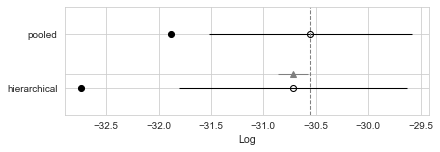

In [24]:
az.plot_compare(df_comp_WAIC);

Диаграмма на рис. 5.8 требует подробного описания:
* незакрашенный (пустой) кружок представляет значения WAIC, а черные
полоски ошибок, связанные с ним, – это значения стандартного отклонения WAIC;
* наименьшее значение WAIC изображено вертикальной штриховой серой линией для упрощения сравнения с другими значениями WAIC;
* черные (закрашенные) кружки – отклонение в пределах выборки для каждой модели: для WAIC – значение 2pWAIC соответствующего значения WAIC;
* для всех моделей, за исключением модели с наивысшей оценкой, также показан значок треугольника, отображающий значение разности WAIC между рассматриваемой моделью и наилучшей моделью, а серая полоска ошибок, связанная с этим значком, – это стандартная ошибка разностей между WAIC с наивысшей оценкой и значением WAIC для каждой модели.

Простейший способ использования информационных критериев – выполнение процедуры выбора модели. Нужно просто выбрать модель с наименьшим значением информационного критерия и забыть обо всех прочих моделях. 

В такой интерпретации для рассматриваемого выше примера это очень простой выбор – первая модель самая лучшая.


In [25]:
df_comp_LOO = pm.compare({'hierarchical': trace_h, 'pooled': trace_p})#, ic='LOO'
df_comp_LOO

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  war

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pooled,0,-30.5688,0.682042,0,0.550954,0.934437,0,False,log
hierarchical,1,-30.7767,1.072,0.207859,0.449046,1.04856,0.139777,False,log


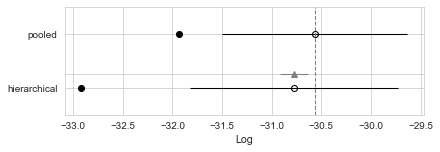

In [26]:
az.plot_compare(df_comp_LOO);

## Выбор одной из трех моделей

Краткое описание модели:
мы хотим исследовать состав молока у нескольких видов приматов, предполагается, что самки приматов с большим мозгом производят более питательное молоко (в общем, это предположение исходит из того, что развития большего объема мозга требуется более калорийное молоко). 

Это важный вопрос для эволючионного развития, и мы попытаемся дать и ответить на него. 

Мы будем использовать 3 переменные, две прогнозирующие переменные: доля неокортекса по сравнению с общей массой мозга (отвечает за высшие нервные функции, например речь) и  массы тела самки, а для прогнозируемой переменной, килокалорий на грамм молока. 

С этими переменными мы собираемся построить 3 различные линейные модели:

* Модель, использующая только процент неокортекса в коре головного мозга
* Модель, использующая только массу тела
* Модель с использованием обеих переменных

In [27]:

df = pd.read_csv('milk.csv', sep =';')
df = df.dropna().reset_index(drop=True)
display(df.head(3))
df['neocortex']= df['neocortex.perc']/100

d = df[['kcal.per.g','neocortex','mass']].copy()

mn = d.iloc[:,1:].mean()
d.iloc[:,1:] = d.iloc[:,1:] - d.iloc[:,1:].mean() 
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
2,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54


,kcal.per.g,neocortex,mass
0,0.49,-0.124159,-14.687647
1,0.47,-0.030359,-11.387647
2,0.56,-0.030359,-11.267647
3,0.89,0.000641,-14.127647
4,0.92,0.012741,-15.957647


In [28]:
##############
mass_shared = theano.shared(d['mass'].values)
neocortex_shared = theano.shared(d['neocortex'].values)
##############

with pm.Model() as model_0:
     
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 10)

    mu = alpha + beta * neocortex_shared

    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])
    trace_0 = pm.sample(2000)

with pm.Model() as model_1:
    
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 10)

    mu = alpha + beta * mass_shared
    
    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])

    trace_1 = pm.sample(2000)

with pm.Model() as model_2:
   
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal('sigma', 10)

    mu = alpha + pm.math.dot(beta, [neocortex_shared,mass_shared])

    kcal = pm.Normal('kcal', mu=mu, sigma=sigma, observed=d['kcal.per.g'])

    trace_2 = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, beta, alpha]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, beta, alpha]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, beta, alpha]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 10 seconds.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


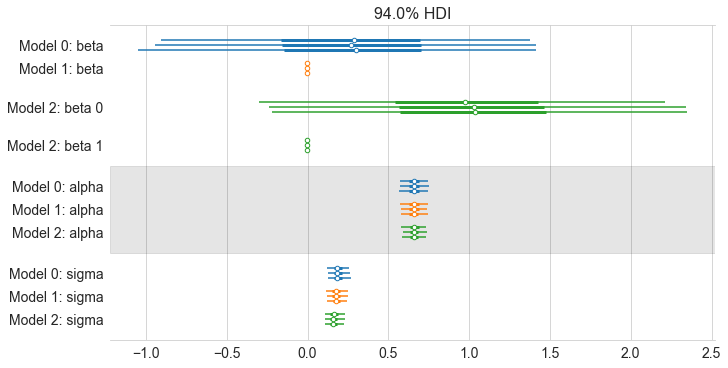

In [29]:
traces = [trace_0, trace_1, trace_2]
az.plot_forest(traces, figsize=(10, 5));

In [30]:
model_dict = dict(zip(['model_0', 'model_1', 'model_2'], traces))
comp = az.compare(model_dict,ic="waic", method='BB-pseudo-BMA')
comp

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  war

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,6.11671,2.21106,0,0.711269,1.5918,0,False,log
model_1,1,4.51535,1.95324,1.60137,0.177958,1.69066,0.889772,False,log
model_0,2,3.89224,1.74635,2.22447,0.110773,1.27047,1.07311,False,log


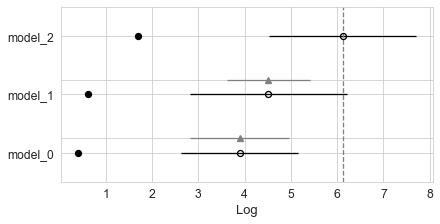

In [31]:
az.plot_compare(comp);

Мы можем видеть, что лучшая модель - модель_2, модель с двумя переменными. Обратите внимание, что DataFrame упорядочен от WAIC от меньшего к большему (т.е. от лучшей к худшей модели).

Мы также можем увидеть, что мы получаем столбец с относительным весом для каждой модели . 

Этот вес можно приблезительно интерпретировать - с какой вероятностью каждая модель сделает правильные прогнозы на будущих данных. 

Конечно, эта интерпретация зависит от моделей, используемых для вычисления весов, если мы добавим или удалим модели, веса будут меняться. А также зависит от предположений, лежащих в основе WAIC (или любого другого используемого критерия информации). Поэтому постарайтесь не переоценивать эти веса.


Теперь мы будем использовать совокупные веса для генерации прогнозов, основанных не на одной модели, а на взвешенном наборе моделей. 

Это один из способов усреднения модели. Используя PyMC3, мы можем вызвать функцию sample_posterior_predictive_w следующим образом:

In [32]:
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, [model_0, model_1, model_2],
                        weights=comp.weight.sort_index(ascending=True),
                        progressbar=False)

In [33]:
ppc_2 = pm.sample_posterior_predictive(trace = trace_2, samples = 1000, model = model_2,
                     progressbar=False)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


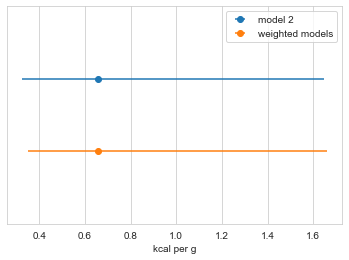

In [34]:
mean_w = ppc_w['kcal'].mean()
hpd_w = pm.hpd(ppc_w['kcal']).mean(axis = 0)

mean_2 = ppc_2['kcal'].mean()
hpd_2 = pm.hpd(ppc_2['kcal']).mean(axis = 0)

plt.errorbar(mean_2, 1, xerr=np.array([hpd_2]).T, fmt='o', label='model 2');
plt.errorbar(mean_w, 0, xerr=np.array([hpd_w]).T, fmt='o', label='weighted models')

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel('kcal per g')
plt.legend();

In [35]:
kcal_per_g = np.zeros(30)                   # калорийность (будем искать)
neocortex = np.linspace(0.5, 0.8, 30)-mn[0] # доля неокортекса
mass = np.full(30, 4.5)-mn[1]               # масса тела (одинакова)

mass_shared.set_value(mass)
neocortex_shared.set_value(neocortex)

post_pred = pm.sample_posterior_predictive(
        trace = trace_2, 
        model=model_2,
        samples=5000)


milk_ensemble = pm.sample_posterior_predictive_w(
        traces = [trace_0, trace_1, trace_2], 
        models = [model_0, model_1, model_2],
        weights= comp.weight.sort_index(ascending=True),
        samples=5000 
        )
            


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


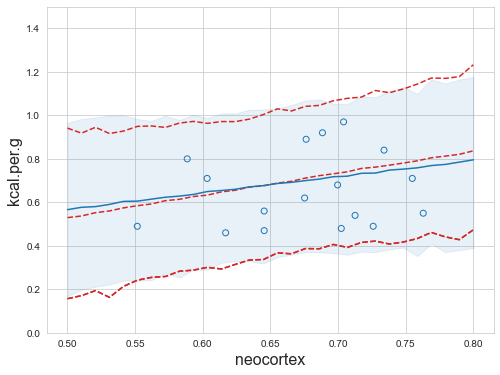

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(neocortex+mn[0], post_pred['kcal'].mean(0), ls='--', color='C3')
hpd_post_pred = pm.hpd(post_pred['kcal'])
plt.plot(neocortex+mn[0],hpd_post_pred[:,0], ls='--', color='C3')
plt.plot(neocortex+mn[0],hpd_post_pred[:,], ls='--', color='C3')

plt.plot(neocortex+mn[0], milk_ensemble['kcal'].mean(0), color='C0')
hpd_av = pm.hpd(milk_ensemble['kcal'])
plt.fill_between(neocortex+mn[0], hpd_av[:,0], hpd_av[:,1], alpha=0.1, color='C0')

plt.scatter(d['neocortex']+mn[0], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0, 1.5)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);